In [8]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import pickle
%matplotlib widget

PROJECT_ROOT = os.path.abspath(os.path.join(os.path.abspath('../..'),os.pardir))
sys.path.append(PROJECT_ROOT)

from electronTransportCode.SimulationDomain import SimulationDomain
from electronTransportCode.Material import unitDensityMaterial
from electronTransportCode.SimOptions import KDTestSource
from electronTransportCode.ParticleModel import DiffusionTestParticlev2
from electronTransportCode.MCParticleTracer import AnalogParticleTracer
from electronTransportCode.MCEstimator import TrackEndEstimator


In [9]:
# Load all simulation results from data/
timingsK, timingsKD, scatteringRateList, dS, collisionsK, collisionsKD = pickle.load(open('data/timings.pkl', 'rb'))
print(timingsK)
print(timingsKD)

[[ 0.4297851   0.43256894  0.44699967  0.4621158   0.45821881]
 [ 0.47230004  0.46735506  0.46937147  0.47371154  0.48813049]
 [ 0.53424638  0.52132136  0.53296301  0.51471141  0.52550771]
 [ 0.66703834  0.65356218  0.64579514  0.65272408  0.66575583]
 [ 1.00239877  0.95889108  0.96560085  0.98558127  0.98699739]
 [ 1.90766171  1.98000706  2.02980193  1.96619466  1.94904493]
 [ 4.39694062  4.504876    4.3721926   4.40232251  4.40903005]
 [11.06809851 11.12464273 11.17531078 11.21295231 11.12186008]
 [29.70033489 29.91341879 30.19844829 29.80687852 29.96731348]
 [81.46961654 81.43055287 82.21428754 82.08016068 81.99122813]]
[[0.47351897 0.47784248 0.46291374 0.47698653 0.4721204 ]
 [0.51244921 0.51582965 0.51709954 0.49965913 0.52971135]
 [0.62414429 0.61688749 0.62960425 0.65019961 0.64582386]
 [0.84061527 0.81122722 0.81181897 0.83517604 0.82082942]
 [0.93891619 0.96715281 1.0000352  0.98502314 0.9739331 ]
 [1.05398066 1.05942253 1.05183731 1.04924906 1.06864072]
 [1.05309455 1.183751

In [10]:
# Experimental speed-up
speedUp = timingsK/timingsKD
avgSpeedUp = speedUp.mean(axis=1)
varSpeedUp = speedUp.var(axis=1)

# Theoretical speed-up
Kexp = scatteringRateList*dS
KDexp = 1.0-np.exp(-scatteringRateList*dS)
theoreticalSpeedUp = Kexp/KDexp

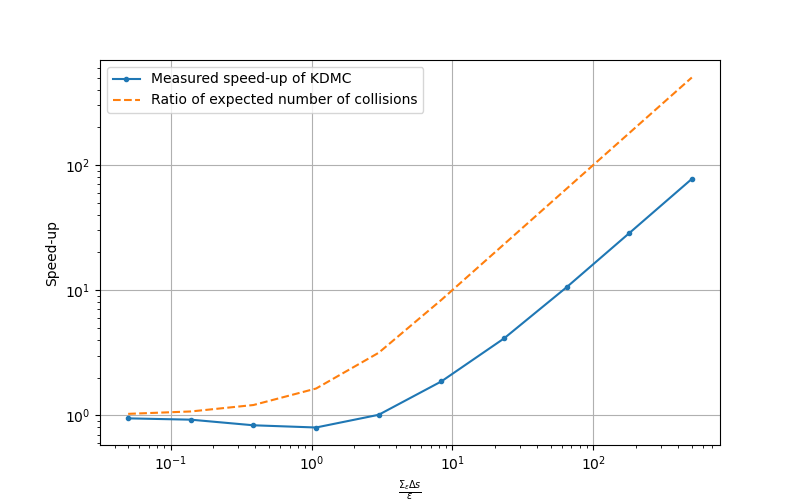

In [11]:
# Plotting
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5.0))

ax1.loglog(scatteringRateList*dS, avgSpeedUp, '.-', label='Measured speed-up of KDMC')
ax1.loglog(scatteringRateList*dS, theoreticalSpeedUp, '--', label='Ratio of expected number of collisions')
ax1.set_xlabel('$ \\frac{ \Sigma_{\epsilon} \Delta s}{\epsilon}$')
ax1.set_ylabel('Speed-up')
ax1.legend()
ax1.grid()

In [12]:
varSpeedUp

array([9.22246003e-04, 2.26906347e-04, 5.82225711e-04, 1.05064181e-04,
       1.14241370e-03, 1.78867706e-03, 2.23412881e-02, 1.21002767e-03,
       6.64476702e-02, 1.75782978e-01])

In [13]:
print(collisionsK)
print(collisionsKD)
print(scatteringRateList*dS)

# The 0.04% is the probability a particle collides within distance 5 of the source with rate 1/100. 
# KDMC is slower than analog particle tracer for low scattering rates because computation of diffusive step is relatively expensive. Diffusive step only makes sense when it accumulates a lot of small kinetic steps, i.e. the scattering rate is high. In this case, one diffusive step is much faster compared many small analog steps, hence the large speed-up when the scattering rate is large.   

# Discuss second table below: when the avarge amount of diffusive steps levels off at 1, the executation time also levels off. The analog particle tracers execution time continues to increase with the scattering rate, hence the crazy spead up.

[  1.04116165   1.13536541   1.37585503   2.07704308   3.9851194
   9.36913477  24.19236769  65.50210008 180.78231129 501.01344054]
[[1.         0.04128165]
 [1.         0.12624505]
 [1.         0.30961238]
 [1.         0.6573863 ]
 [1.         0.94611784]
 [1.         0.99963999]
 [1.         1.        ]
 [1.         1.        ]
 [1.         1.        ]
 [1.         1.        ]]
[5.00000000e-02 1.39127970e-01 3.87131841e-01 1.07721735e+00
 2.99742125e+00 8.34050269e+00 2.32079442e+01 6.45774833e+01
 1.79690683e+02 5.00000000e+02]


In [14]:
NB_PARTICLES = 10
xmax = 25
ymin = -xmax; ymax = xmax; ybins = 1  # No internal grid cell crossings
zmin = -xmax; zmax = xmax; zbins = 1
simDomain = SimulationDomain(ymin, ymax, zmin, zmax, ybins, zbins, material=unitDensityMaterial)
eSource = 5.0
pointSourceSim = KDTestSource(minEnergy=0.0, rngSeed=4, eSource=eSource)
particle = DiffusionTestParticlev2(Es=0.07, sp=1.0)
warmUpEstimator1 = TrackEndEstimator(simDomain, nb_particles=NB_PARTICLES, setting='x')
warmUpEstimator2 = TrackEndEstimator(simDomain, nb_particles=NB_PARTICLES, setting='x')

particleTracerKD = KDParticleTracer(particle=particle, simOptions=pointSourceSim, simDomain=simDomain, dS = eSource)  # stepsize is final time!
particleTracerK = AnalogParticleTracer(particle=particle, simOptions=pointSourceSim, simDomain=simDomain)  # stepsize is final time!